In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
 
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
 
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
 
%matplotlib inline
%config InlineBackend.figure_format='retina'
 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
 
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
 
rcParams['figure.figsize'] = 12, 8
 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\86134\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("C:/Users/86134/Desktop/毕业设计/data/SemEval2014/Laptop_Train_v2.csv")

In [3]:
df.shape

(2358, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358 entries, 0 to 2357
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2358 non-null   int64 
 1   content     2358 non-null   object
 2   AspectTerm  2358 non-null   object
 3   polarity    2358 non-null   object
 4   from        2358 non-null   int64 
 5   to          2358 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 110.7+ KB


In [5]:
def to_sentiment(polarity):
    polarity = str(polarity)
    if polarity == 'negative':
        return 0
    elif polarity == 'neutral':
        return 1
    else:
        return 2
 
df['sentiment'] = df.polarity.apply(to_sentiment)
 
class_names = ['negative', 'neutral', 'positive']


In [6]:
PRE_TRAINED_MODEL_NAME= 'bert-base-cased'

In [7]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
MAX_LEN = 160

In [9]:
class GPReviewDataset(Dataset):
 
    def __init__(self, reviews, review_aspects, targets, tokenizer, max_len):
        self.reviews = reviews
        self.review_aspects = review_aspects
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
 
    def __len__(self):
        return len(self.reviews)
 
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
 
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [10]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)
 
df_train.shape, df_val.shape, df_test.shape

((2122, 7), (118, 7), (118, 7))

In [11]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        review_aspects = df.AspectTerm.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
 
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )
 
BATCH_SIZE = 4
 
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [12]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\86134\anaconda3\envs\pytorch\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [13]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


In [14]:
data['input_ids']

tensor([[  101, 18821,  1766,   118,  1332,  3402,  1106,  1139,   124,  1989,
          1385,  4503,  1349,  2596,  1175,   146,  3742,  2541,  1251,  3719,
          1107,  2099,   113,   123,   119,   124,   144,  3048,  1584,   191,
           120,   188,   123,   119,   125,   144,  3048,  1584,   114,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [15]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
class SentimentClassifier(nn.Module):
 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, output_hidden_states=True, output_attentions=True, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
 
    def forward(self, input_ids, attention_mask):
        _, pooled_output,_,_ = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [17]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
#input_ids = data['input_ids'].to(device)
#attention_mask = data['attention_mask'].to(device)
 
#print(input_ids.shape) # batch size x seq length
#print(attention_mask.shape) # batch size x seq length

In [19]:
#torch.nn.functional.softmax(model(input_ids, attention_mask), dim=1)

In [20]:
EPOCHS = 10
 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
 
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
 
loss_fn = nn.CrossEntropyLoss().to(device)

C:\Users\86134\anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
  ):
    model = model.train()
 
    losses = []
    correct_predictions = 0
 
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        #input_ids = input_ids.squeeze(0)
        attention_mask = d["attention_mask"].to(device)
        #attention_mask = attention_mask.squeeze(0)
        #print(input_ids.shape) # batch size x seq length
        #print(attention_mask.shape) # batch size x seq length
        targets = d["targets"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
 
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
 
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
 
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
 
    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
 
    losses = []
    correct_predictions = 0
 
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
 
            loss = loss_fn(outputs, targets)
 
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
 
    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
%%time
 
history = defaultdict(list)
best_accuracy = 0
 
for epoch in range(EPOCHS):
 
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
 
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
 
    print(f'Train loss {train_loss} accuracy {train_acc}')
 
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
 
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
 
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
 
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6508777379689706 accuracy 0.8067860508953817
Val   loss 1.0101994916486243 accuracy 0.7542372881355932

Epoch 2/10
----------
Train loss 0.5189696955034183 accuracy 0.8722902921771913
Val   loss 1.0726918102552494 accuracy 0.771186440677966

Epoch 3/10
----------
Train loss 0.4460214504078925 accuracy 0.8897266729500471
Val   loss 1.0825671553844587 accuracy 0.7796610169491526

Epoch 4/10
----------
Train loss 0.40802342781692696 accuracy 0.8977379830348727
Val   loss 1.2435544065471429 accuracy 0.7796610169491526

Epoch 5/10
----------
Train loss 0.3780008438530004 accuracy 0.9010367577756833
Val   loss 1.2879011541449776 accuracy 0.7542372881355932

Epoch 6/10
----------
Train loss 0.33182521123967873 accuracy 0.9071630537229028
Val   loss 1.3467640131595544 accuracy 0.788135593220339

Epoch 7/10
----------
Train loss 0.31290070602574727 accuracy 0.9104618284637135
Val   loss 1.301984897160825 accuracy 0.788135593220339

Epoch 8/10
----------
Train 

In [23]:
##没有什么用的分割线
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
 
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 160])
torch.Size([4, 160])


ValueError: x and y must have same first dimension, but have shapes (0,) and (1,)

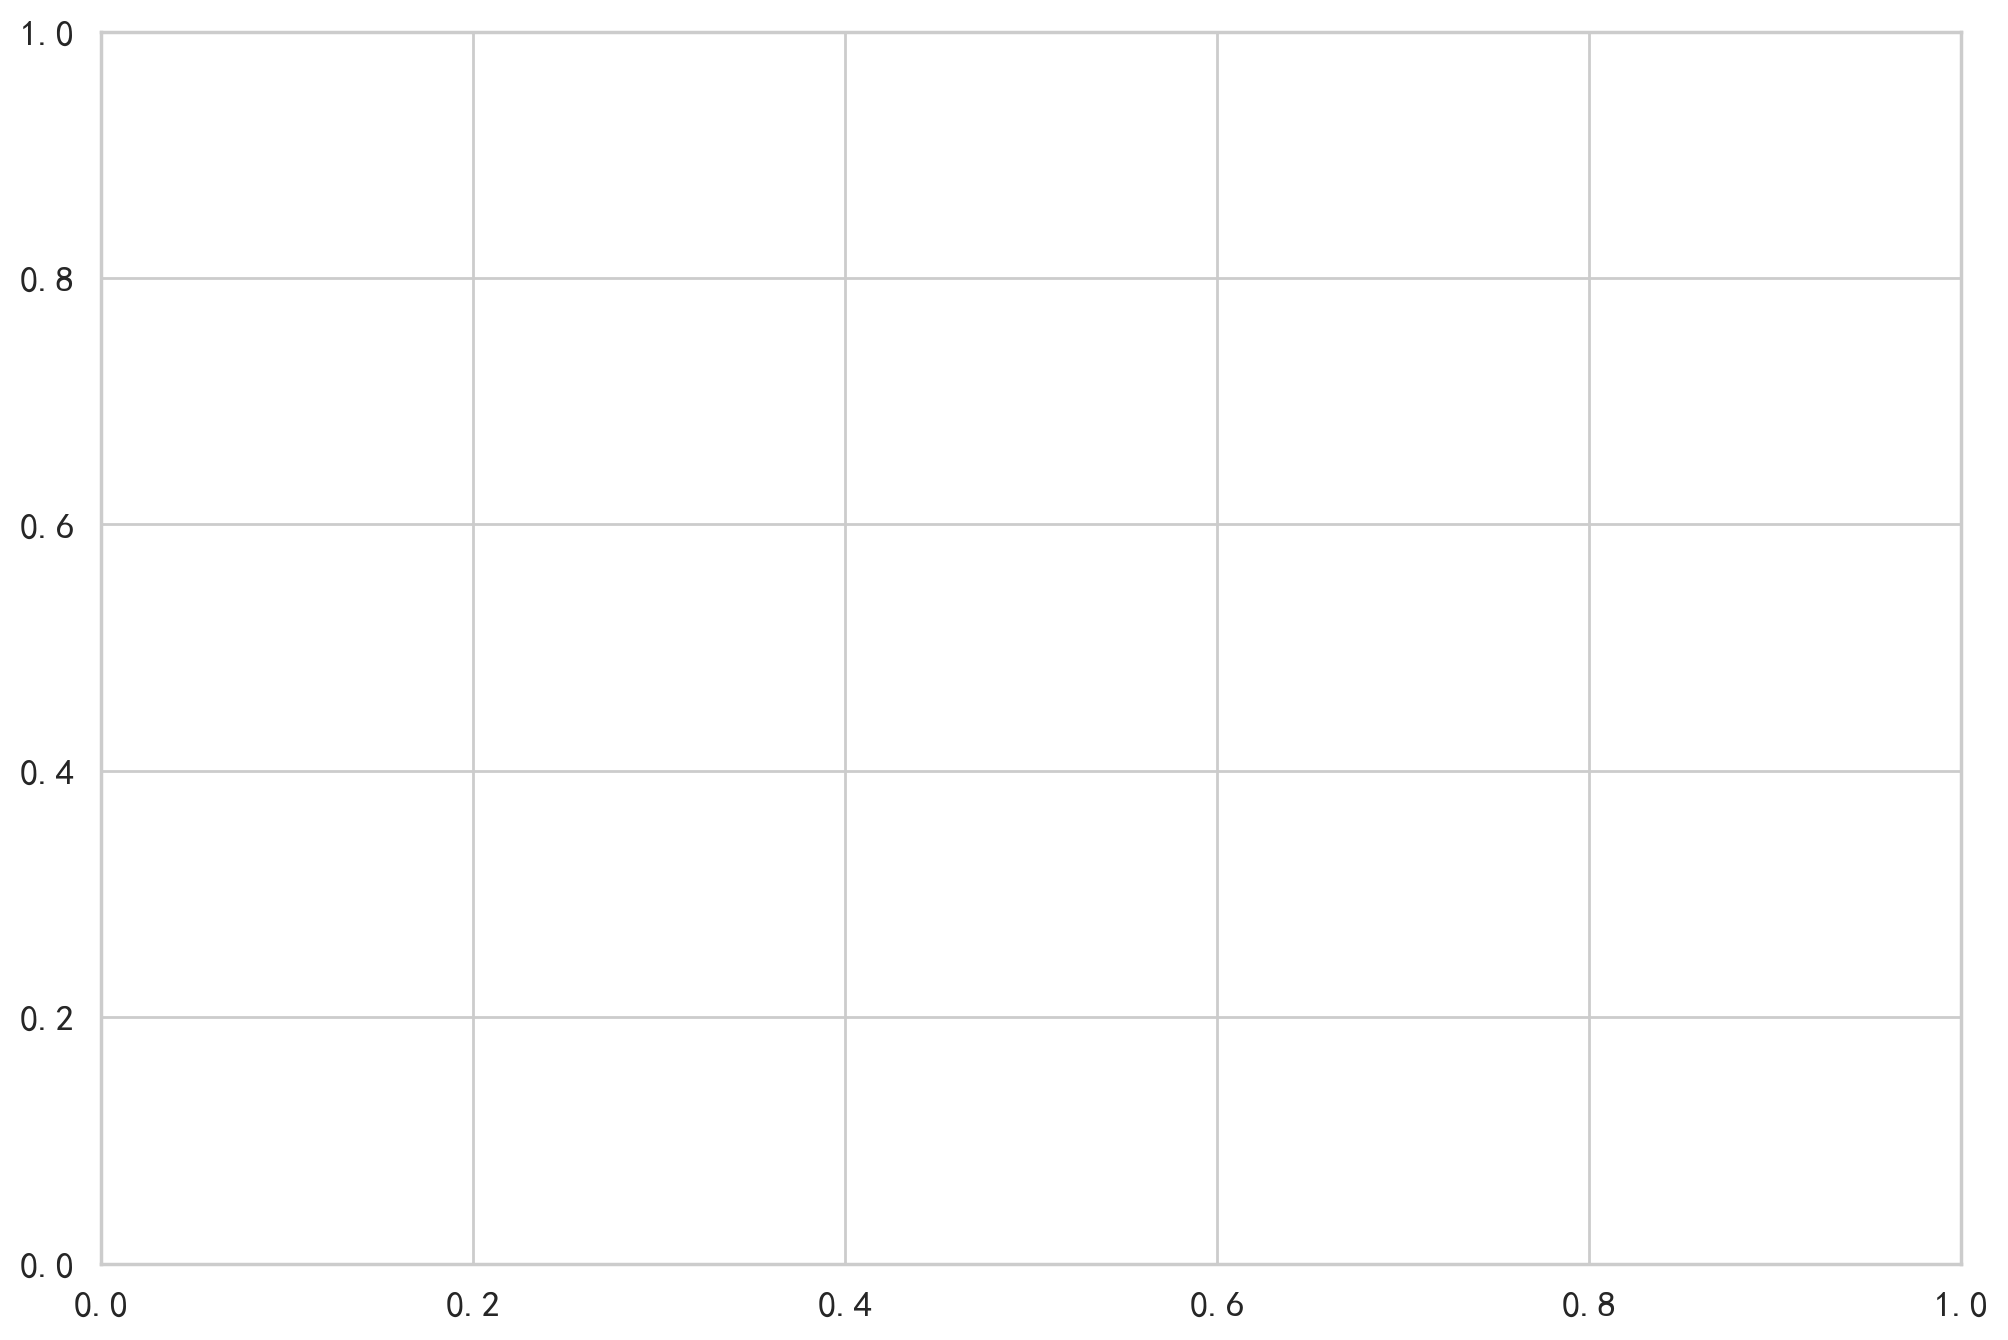

In [52]:

plt.plot(history['train_acc.item()'],[1], label='train accuracy')
plt.plot(history['val_acc.item()'],[1], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.xlim([0,10]);
plt.show()

In [36]:
history['train_acc']

[tensor(0.3974, device='cuda:0', dtype=torch.float64),
 tensor(0.5767, device='cuda:0', dtype=torch.float64),
 tensor(0.6731, device='cuda:0', dtype=torch.float64),
 tensor(0.7364, device='cuda:0', dtype=torch.float64),
 tensor(0.7923, device='cuda:0', dtype=torch.float64),
 tensor(0.8317, device='cuda:0', dtype=torch.float64),
 tensor(0.8639, device='cuda:0', dtype=torch.float64),
 tensor(0.8850, device='cuda:0', dtype=torch.float64),
 tensor(0.9031, device='cuda:0', dtype=torch.float64),
 tensor(0.9123, device='cuda:0', dtype=torch.float64)]

In [37]:
history['val_acc']

[tensor(0.5248, device='cuda:0', dtype=torch.float64),
 tensor(0.6468, device='cuda:0', dtype=torch.float64),
 tensor(0.6709, device='cuda:0', dtype=torch.float64),
 tensor(0.7255, device='cuda:0', dtype=torch.float64),
 tensor(0.7357, device='cuda:0', dtype=torch.float64),
 tensor(0.7637, device='cuda:0', dtype=torch.float64),
 tensor(0.7662, device='cuda:0', dtype=torch.float64),
 tensor(0.7903, device='cuda:0', dtype=torch.float64),
 tensor(0.8030, device='cuda:0', dtype=torch.float64),
 tensor(0.8043, device='cuda:0', dtype=torch.float64)]

In [73]:
#调用训练好的模型
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)
test_acc.item()

0.8185279187817258

In [75]:
def get_predictions(model, data_loader):
    model = model.eval()
 
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
 
    with torch.no_grad():
        for d in data_loader:
 
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
 
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
 
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
 
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [76]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [77]:
idx = 2
 
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})
 
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


In [78]:
review_text = "Hate you!!!"

In [79]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

C:\Users\86134\anaconda3\envs\pytorch\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
 
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
 
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Hate you!!!
Sentiment  : negative
